In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from shapely import Polygon
import geopandas as gpd

In [2]:
geom = Polygon([
    (-91.3011932, 33.852768),
    (-90.9098053, 33.8413567),
    (-90.9194183, 33.5069017),
    (-91.2957001, 33.509193),
    (-91.3005066, 33.8579026)
])

gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326")
gdf = gdf.to_crs(32615)  # UTM 15N
selected_geom = gdf.geometry.union_all().envelope

In [3]:
items_gdf = pc_query(
    collections="landsat-c2-l2",
    geometry=selected_geom,
    datetime="1984/2024",
    crs=gdf.crs,
    query={"eo:cloud_cover": {"lt": 50}} # return scenes with less than 50% cloud cover 
)
print(f"Found {len(items_gdf)} items")

Found 3218 items


In [4]:
client = Client(n_workers=os.cpu_count(), memory_limit="4GB")
display(client)

/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61141 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61141/status,
Dashboard: http://127.0.0.1:61141/status,Workers: 10
Total threads: 10,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61142,Workers: 0
Dashboard: http://127.0.0.1:61141/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:61190,Total threads: 1
Dashboard: http://127.0.0.1:61192/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:61145,


Task exception was never retrieved
future: <Task finished name='Task-1200584' coro=<Client._gather.<locals>.wait() done, defined at /Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


In [5]:
da = prepare_timeseries(
    items_gdf.iloc[-256:],
    geometry=selected_geom,
    crs=gdf.crs,
    bands=["green", "nir08", "qa_pixel"],
    chunks={"time": 1, "x": 512, "y": 512},
    masked=True,
    max_workers=4,
    reproject_num_threads=-1,  # Use all available CPUs for reprojection
    reproject_mem_limit=256,  # 256 MB memory limit for reprojection
)

Processing items: 100%|██████████| 147/147 [11:18<00:00,  4.62s/timestep]


In [11]:
da.compute()

/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/dask/array/chunk.py:279: Runtim

<xarray.DataArray (time: 147, band: 3, y: 1289, x: 1208)> Size: 3GB
array([[[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
...
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]]],
      shape=(147, 3, 1289, 1208), dtype=float32)
Coordinates:
  * x            (x) float64 10kB 6.572e+05 6.572e+05 ... 6.934e+05 6.934e+05
  * y            (y) float64 10kB 3.709e+06 3.709e+06 ... 3.748e+06 3.748e+06
  * band         (band) <U8 96B 'green' 'nir08' 'qa_pixel'
  * time         (time) datetime64[ns] 1kB 1984-04-20 1984-04-29 ... 1991-04-01
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
qa = da.sel(band="qa_pixel").astype("uint32")

mask = (
    ((qa & (1 << 3)) == 0) &  # cloud
    ((qa & (1 << 4)) == 0) &  # cloud shadow
    ((qa & (1 << 5)) == 0) &  # snow
    ((qa & (1 << 7)) == 0)    # water
)

da = da.where(~mask)

In [28]:
# apply da.rio.interpolat_na(method='linear') to fill NaN values per time step
from tqdm import tqdm
for timestep in tqdm(da.time):
    da_timestep = da.sel(time=timestep)
    da_timestep = da_timestep.rio.interpolate_na(method='linear')
    da.loc[dict(time=timestep)] = da_timestep

  0%|          | 0/147 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [23]:
def dn2sr(da):
    """
    Convert Digital Number (DN) to Surface Reflectance (SR) for Landsat Collection 2 Level 2 data.
    See https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
    """
    return (da * 0.0000275) - 0.2

def calculate_ndwi(da):
    """Calculate NDWI from green and nir bands."""
    green = dn2sr(da.sel(band="green"))
    nir = dn2sr(da.sel(band="nir08"))
    
    ndwi = (green - nir) / (green + nir)
    ndwi = ndwi.clip(-1, 1)  # Clip values to [-1, 1]
    return ndwi

ndwi = calculate_ndwi(da)
yearly_ndwi = ndwi.resample(time="1Y").mean().compute()

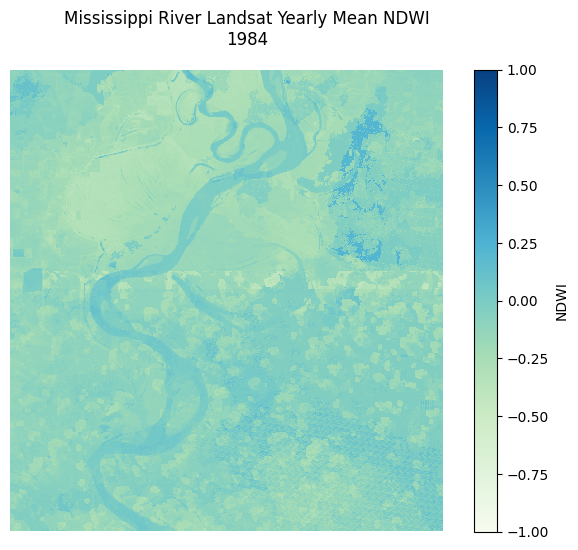

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    yearly_ndwi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='GnBu', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    
    fig.suptitle(f"Mississippi River Landsat Yearly Mean NDWI\n" + \
                    f"{yearly_ndwi['time'][frame].dt.strftime('%Y').values}")
    
init_plot = yearly_ndwi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'NDWI'}, cmap='GnBu', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(yearly_ndwi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once'))

In [ ]:
items_gdf['properties.datetime']

0      2024-12-31 16:37:36.266
1      2024-12-07 16:37:10.143
2      2024-12-06 16:43:48.984
3      2024-12-06 16:43:25.093
4      2024-11-29 16:37:45.106
                 ...          
2280   1984-06-23 16:12:05.118
2281   1984-06-23 16:11:41.287
2282   1984-06-07 16:11:50.139
2283   1984-05-06 16:10:59.176
2284   1984-04-29 16:04:36.633
Name: properties.datetime, Length: 2285, dtype: datetime64[ms]